## Tabular Playground - November 2021

In [1]:
# Basic Data Preprocessing
import numpy as np
import pandas as pd 

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Data Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler,MinMaxScaler
from scipy.stats import uniform, randint

# Feature Selection
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.decomposition import PCA

#Modelling
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow import keras

# Metrics
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score
from sklearn import metrics
from sklearn.model_selection import cross_val_score,GridSearchCV, KFold, RandomizedSearchCV,RepeatedStratifiedKFold
from skopt import BayesSearchCV


In [2]:
# Reading Test and Train data 
# Dropping ID column
train_df= pd.read_csv('../input/tabular-playground-series-nov-2021/train.csv').iloc[:,1:]
test_df= pd.read_csv('../input/tabular-playground-series-nov-2021/test.csv')

In [3]:
# Create new DF without ID column from scoring dataset
test_df_X = test_df.iloc[:,1:]
# Create DF of ID column to be used later while submission
test_df_id = test_df.iloc[:,:1]

In [4]:
# Function to Remove outliers from data
def remove_outliers(x):
    upper_limit = x.mean() + (2*x.std())
    lower_limit = x.mean() - (2*x.std())
    return np.where(x > upper_limit,upper_limit,np.where(x <lower_limit,lower_limit,x))

In [5]:
# Remove outliers for Train dataset
train_df = train_df.apply(lambda x: remove_outliers(x))

# Seperate target from Train Dataset
train_df_Y = train_df.target
train_df_X = train_df.iloc[:,:100]

In [6]:
train_df_X.dtypes.unique()

array([dtype('float64')], dtype=object)

In [7]:
df_cat_variables = train_df_X.select_dtypes('int64').astype('int8')
df_cont_variables = train_df_X.select_dtypes('float64').astype('float32')

In [8]:
# Scale and transform dataset
def data_scaler_fit(option,df):
    if option == 1:
        transformer = StandardScaler().fit(df)
    if option == 2 :
        transformer = RobustScaler().fit(df)
    if option ==3 :
        transformer = MinMaxScaler().fit(df)
    return transformer

In [9]:
"""
# Tanh estimator : https://stackoverflow.com/questions/43061120/tanh-estimator-normalization-in-python
m = np.mean(unnormalizedData, axis=0) # array([16.25, 26.25])
std = np.std(unnormalizedData, axis=0) # array([17.45530005, 22.18529919])

data = 0.5 * (np.tanh(0.01 * ((unnormalizedData - m) / std)) + 1)
"""

'\n# Tanh estimator : https://stackoverflow.com/questions/43061120/tanh-estimator-normalization-in-python\nm = np.mean(unnormalizedData, axis=0) # array([16.25, 26.25])\nstd = np.std(unnormalizedData, axis=0) # array([17.45530005, 22.18529919])\n\ndata = 0.5 * (np.tanh(0.01 * ((unnormalizedData - m) / std)) + 1)\n'

In [10]:
transformer = data_scaler_fit(3,df_cont_variables)

In [11]:
train_df_X = transformer.transform(df_cont_variables)
test_df_X = transformer.transform(test_df_X[df_cont_variables.columns])

#train_df_X = df_cont_variables.to_numpy()
#test_df_X = test_df_X[df_cont_variables.columns].to_numpy()

In [12]:
# Use PCA for dimention reduction
"""
pca = PCA(0.95)
pca.fit(train_df_X)

train_df_X = pca.transform(train_df_X)
test_df_X = pca.transform(test_df_X)
"""

'\npca = PCA(0.95)\npca.fit(train_df_X)\n\ntrain_df_X = pca.transform(train_df_X)\ntest_df_X = pca.transform(test_df_X)\n'

In [13]:
"""
model = XGBClassifier(objective = 'binary:logistic',eval_metric="auc",random_state=1542,use_label_encoder=False,tree_method = 'gpu_hist')


# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# params = {
  #      "colsample_bytree": uniform(0.7, 0.3),
   #     "gamma": uniform(0, 0.5),
    #    "learning_rate": uniform(0.03, 0.3), # default 0.1 
     #   "max_depth": randint(2, 8), # default 3
      #  "n_estimators": randint(100, 1000), # default 100
       # "subsample": uniform(0.6, 0.4)
  #  }


param_grid = {
    "eta":(0.01,0.2,'uniform') ,
    "learning_rate": (0.0001, 0.3, "log-uniform"),
    "n_estimators": (100,  1000) ,
    "max_depth": (2, 12) ,
    "colsample_bytree": (0.3, 0.7,'uniform'),
    "gamma": (0, 0.5,'uniform'),
    "subsample": (0.4, 1.0)
}


search = GridSearchCV(model, param_grid, cv=cv, verbose=1, n_jobs=1, scoring='roc_auc',return_train_score=True,refit=True)

search.fit(X_train, y_train,eval_set=[(X_test, y_test)])

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", search.best_estimator_)
print("\n The best score across ALL searched params:\n", search.best_score_)
print("\n The best parameters across ALL searched params:\n", search.best_params_)
"""

'\nmodel = XGBClassifier(objective = \'binary:logistic\',eval_metric="auc",random_state=1542,use_label_encoder=False,tree_method = \'gpu_hist\')\n\n\n# define evaluation\ncv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)\n\n# params = {\n  #      "colsample_bytree": uniform(0.7, 0.3),\n   #     "gamma": uniform(0, 0.5),\n    #    "learning_rate": uniform(0.03, 0.3), # default 0.1 \n     #   "max_depth": randint(2, 8), # default 3\n      #  "n_estimators": randint(100, 1000), # default 100\n       # "subsample": uniform(0.6, 0.4)\n  #  }\n\n\nparam_grid = {\n    "eta":(0.01,0.2,\'uniform\') ,\n    "learning_rate": (0.0001, 0.3, "log-uniform"),\n    "n_estimators": (100,  1000) ,\n    "max_depth": (2, 12) ,\n    "colsample_bytree": (0.3, 0.7,\'uniform\'),\n    "gamma": (0, 0.5,\'uniform\'),\n    "subsample": (0.4, 1.0)\n}\n\n\nsearch = GridSearchCV(model, param_grid, cv=cv, verbose=1, n_jobs=1, scoring=\'roc_auc\',return_train_score=True,refit=True)\n\nsearch.fit(X_t

In [14]:
"""
def training_models(model_type):
    # Stochastic Gradient Descent
    if model_type == 'SGD':
        model = SGDClassifier(loss="log", penalty="l2", max_iter=100)
    
    # Multi-layer Perceptron
    if model_type == 'MLP':
        model = MLPClassifier(alpha=1e-5,solver = 'sgd',learning_rate = 'adaptive',warm_start=True,early_stopping = True,
                              max_iter=500,random_state=1)
    # Decision Tree
    if model_type == 'DTC':
        model = DecisionTreeClassifier(max_depth = 10,max_features = 'auto', random_state = 1)
        
    # Random Forest
    if model_type == 'RFC':
        model = RandomForestClassifier(n_jobs = -1,n_estimators=100, warm_start=True,random_state = 1)
    
    # Gradient Boosting Classifier
    if model_type == 'GBC':
        model = GradientBoostingClassifier(loss= 'exponential',learning_rate = 0.05,n_estimators=500,max_depth=10,criterion='squared_error')
        
    # XG Boost
    if model_type == 'XGB':
        model = XGBClassifier(objective = 'binary:logistic',n_estimators=1000,eval_metric="auc",random_state=1542,tree_method = 'gpu_hist',use_label_encoder=False)
    
    
    return model
"""

'\ndef training_models(model_type):\n    # Stochastic Gradient Descent\n    if model_type == \'SGD\':\n        model = SGDClassifier(loss="log", penalty="l2", max_iter=100)\n    \n    # Multi-layer Perceptron\n    if model_type == \'MLP\':\n        model = MLPClassifier(alpha=1e-5,solver = \'sgd\',learning_rate = \'adaptive\',warm_start=True,early_stopping = True,\n                              max_iter=500,random_state=1)\n    # Decision Tree\n    if model_type == \'DTC\':\n        model = DecisionTreeClassifier(max_depth = 10,max_features = \'auto\', random_state = 1)\n        \n    # Random Forest\n    if model_type == \'RFC\':\n        model = RandomForestClassifier(n_jobs = -1,n_estimators=100, warm_start=True,random_state = 1)\n    \n    # Gradient Boosting Classifier\n    if model_type == \'GBC\':\n        model = GradientBoostingClassifier(loss= \'exponential\',learning_rate = 0.05,n_estimators=500,max_depth=10,criterion=\'squared_error\')\n        \n    # XG Boost\n    if mode

In [15]:
"""
def feature_selection(model_type,train_X,train_Y):
    embeded_selector = SelectFromModel(training_models(model_type), threshold='1.25*median')
    embeded_selector.fit(train_X,train_Y)
    embeded_support = embeded_selector.get_support()
    embeded_feature = pd.DataFrame(train_X).loc[:,embeded_support].columns.tolist()
    return embeded_feature

"""

"\ndef feature_selection(model_type,train_X,train_Y):\n    embeded_selector = SelectFromModel(training_models(model_type), threshold='1.25*median')\n    embeded_selector.fit(train_X,train_Y)\n    embeded_support = embeded_selector.get_support()\n    embeded_feature = pd.DataFrame(train_X).loc[:,embeded_support].columns.tolist()\n    return embeded_feature\n\n"

In [16]:
# final_features = feature_selection('GBC',train_df_X, train_df_Y)

In [17]:
# Divide into train and test
X_train, X_test, y_train, y_test = train_test_split(train_df_X, train_df_Y, test_size=0.20, random_state=151)

In [18]:
"""
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

model = MLPClassifier(warm_start=True,early_stopping = True,max_iter=500,random_state=1)

search = GridSearchCV(model, parameter_space, cv=3, verbose=1, n_jobs=-1, scoring='roc_auc',return_train_score=True,refit=True)

search.fit(X_train, y_train)


print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", search.best_estimator_)
print("\n The best score across ALL searched params:\n", search.best_score_)
print("\n The best parameters across ALL searched params:\n", search.best_params_)

model = search
"""

'\nparameter_space = {\n    \'hidden_layer_sizes\': [(50,50,50), (50,100,50), (100,)],\n    \'activation\': [\'tanh\', \'relu\'],\n    \'solver\': [\'sgd\', \'adam\'],\n    \'alpha\': [0.0001, 0.05],\n    \'learning_rate\': [\'constant\',\'adaptive\'],\n}\n\nmodel = MLPClassifier(warm_start=True,early_stopping = True,max_iter=500,random_state=1)\n\nsearch = GridSearchCV(model, parameter_space, cv=3, verbose=1, n_jobs=-1, scoring=\'roc_auc\',return_train_score=True,refit=True)\n\nsearch.fit(X_train, y_train)\n\n\nprint(" Results from Random Search " )\nprint("\n The best estimator across ALL searched params:\n", search.best_estimator_)\nprint("\n The best score across ALL searched params:\n", search.best_score_)\nprint("\n The best parameters across ALL searched params:\n", search.best_params_)\n\nmodel = search\n'

In [19]:
model = keras.models.Sequential([
keras.layers.Flatten(input_shape=[X_train.shape[1],]),
keras.layers.Dense(512, activation="relu"),
keras.layers.Dropout(0.5),
keras.layers.Dense(128, activation="relu"),
keras.layers.Dropout(0.5),
keras.layers.Dense(64, activation="relu"),
keras.layers.Dense(1, activation="sigmoid")
])

2021-11-30 12:50:16.785542: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 12:50:16.786577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 12:50:16.787192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-30 12:50:16.788595: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 512)               51712     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6

In [21]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
epochs = 100

model.compile(loss="binary_crossentropy",
optimizer="adam",
metrics=[tf.keras.metrics.AUC()])

In [22]:
history = model.fit(X_train, y_train, epochs=epochs,validation_data=(X_test, y_test),callbacks=[callback])

2021-11-30 12:50:19.442489: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
15000/15000 [==============================] - 53s 3ms/step - loss: 0.6125 - auc: 0.7225 - val_loss: 0.5875 - val_auc: 0.7432
Epoch 2/100
15000/15000 [==============================] - 51s 3ms/step - loss: 0.5979 - auc: 0.7347 - val_loss: 0.5850 - val_auc: 0.7445
Epoch 3/100
15000/15000 [==============================] - 47s 3ms/step - loss: 0.5960 - auc: 0.7357 - val_loss: 0.5830 - val_auc: 0.7444
Epoch 4/100
15000/15000 [==============================] - 48s 3ms/step - loss: 0.5943 - auc: 0.7369 - val_loss: 0.5839 - val_auc: 0.7440
Epoch 5/100
15000/15000 [==============================] - 52s 3ms/step - loss: 0.5937 - auc: 0.7370 - val_loss: 0.5833 - val_auc: 0.7439
Epoch 6/100
15000/15000 [==============================] - 48s 3ms/step - loss: 0.5931 - auc: 0.7377 - val_loss: 0.5841 - val_auc: 0.7446
Epoch 7/100
15000/15000 [==============================] - 51s 3ms/step - loss: 0.5926 - auc: 0.7378 - val_loss: 0.5834 - val_auc: 0.7447
Epoch 8/100
15000/15000 [=========

In [23]:
#Train Model

#model = training_models('MLP',X_train,y_train,X_test, y_test)
#del(model)

In [24]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


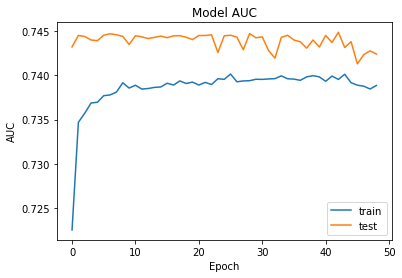

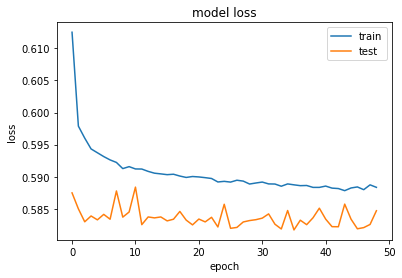

In [25]:
# summarize history for accuracy
plt.plot(history.history[list(history.history.keys())[1]])
plt.plot(history.history[list(history.history.keys())[3]])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [26]:
# Predict on interim test df
target_predict = pd.DataFrame(model.predict(X_test).round().astype(int),columns = ['pred_target'])

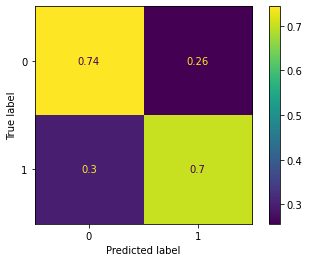

In [27]:
# Calculate and Show Confusion Matrix
conf_metrix = confusion_matrix(y_test,target_predict.to_numpy(), normalize= 'true')
disp = ConfusionMatrixDisplay(confusion_matrix = conf_metrix )
disp.plot()
plt.show()

In [28]:
# Print Accuracy
print('Accuracy: '+ str(accuracy_score(y_test,target_predict.to_numpy()) * 100) + '%')

Accuracy: 72.28916666666667%


### Train Model on Whole data before predicting actual test data

In [29]:
#Train Model
#model = training_models('MLP',train_df_X,train_df_Y.to_numpy(),X_test, y_test)

### Predict and Submit to leaderboard

In [30]:
# Predict on actual test dataset
probability = pd.DataFrame(model.predict(test_df_X),columns = ['target'])

In [31]:
# Submit Predictions
submission = pd.concat([test_df_id,probability],axis = 1)
submission.to_csv('submission.csv',index=False)